In [1]:
# import required libraries
# pandas:Data framework library for Python
# sklearn: Library to perform machine learning tasks
import pandas as pd
import pandas
import numpy as np
import scipy
import scipy.stats as st
import sklearn 
import sklearn.datasets
import sklearn.metrics as metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.feature_selection import mutual_info_classif
from scipy import stats
from datetime import datetime

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
Data_2017 = pd.read_excel("PERM_Disclosure_Data_FY17.xlsx")
Data_2015 = pd.read_excel("PERM_Disclosure_Data_FY15_Q4.xlsx")
Data_2016 = pd.read_excel("PERM_Data_FY16.xlsx")

In [4]:
frames = [Data_2015, Data_2016, Data_2017]

data = pd.concat(frames)
data = data.drop_duplicates()
df = data.copy()

In [213]:
def cart(target,features):
    from sklearn import tree
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    print(pandas.DataFrame(metrics.confusion_matrix(y_test, pred)))
    prob = clf.predict_proba(X_test)
    print("The accuracy score for this training is",metrics.accuracy_score(y_test, pred))
    print(classification_report(y_test, pred))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, prob[:,1], pos_label=1)
    print(metrics.auc(fpr, tpr))
    print(clf.n_features_)
    #return(coef)

In [55]:
i = 0;
for col in df.columns:
    i = i+1;
    print (i-1,"Column: '{}'".format(col),"contains ", np.round(100*df[col].count()/len(df['CASE_STATUS']),decimals=2),"% non-null values" )

0 Column: 'AGENT_CITY' contains  88.37 % non-null values
1 Column: 'AGENT_FIRM_NAME' contains  86.53 % non-null values
2 Column: 'AGENT_STATE' contains  87.04 % non-null values
3 Column: 'CASE_NUMBER' contains  100.0 % non-null values
4 Column: 'CASE_RECEIVED_DATE' contains  100.0 % non-null values
5 Column: 'CASE_STATUS' contains  100.0 % non-null values
6 Column: 'CLASS_OF_ADMISSION' contains  93.32 % non-null values
7 Column: 'COUNTRY_OF_CITIZENSHIP' contains  99.98 % non-null values
8 Column: 'DECISION_DATE' contains  100.0 % non-null values
9 Column: 'EMPLOYER_ADDRESS_1' contains  99.99 % non-null values
10 Column: 'EMPLOYER_ADDRESS_2' contains  32.78 % non-null values
11 Column: 'EMPLOYER_CITY' contains  100.0 % non-null values
12 Column: 'EMPLOYER_COUNTRY' contains  99.97 % non-null values
13 Column: 'EMPLOYER_DECL_INFO_TITLE' contains  99.98 % non-null values
14 Column: 'EMPLOYER_NAME' contains  100.0 % non-null values
15 Column: 'EMPLOYER_NUM_EMPLOYEES' contains  99.97 % non-n

In [7]:
df['PW_AMOUNT_9089'] = df['PW_AMOUNT_9089'].apply(lambda word: str(word).replace("#", ""))
df['PW_AMOUNT_9089'] = df['PW_AMOUNT_9089'].apply(lambda word: str(word).replace(",", ""))
df['PW_AMOUNT_9089'] = df['PW_AMOUNT_9089'].replace({"nan": np.NaN})
df['PW_AMOUNT_9089'] = pd.to_numeric(df['PW_AMOUNT_9089'])

In [8]:
#Dividing our continuous income values into some categories to facilitate their visualization
df['remuneration'] = pd.cut(df['PW_AMOUNT_9089'], [0, 30000, 60000,90000,120000,150000,180000,210000,240000,270000,495748000], right=False, labels=["0-30k", "30-60k","60-90k","90-120k","120-150k","150-180k","180-210k","210-240k","240-270k","270k+"])
salary = df['remuneration'].value_counts()
salary.iloc[np.argsort(salary.index)]

0-30k        27066
30-60k       38541
60-90k      105890
90-120k      99953
120-150k     30911
150-180k      6563
180-210k      3055
210-240k       698
240-270k        36
270k+           20
Name: remuneration, dtype: int64

In [18]:
df['YEAR'] = df['DECISION_DATE'].dt.year

In [321]:
#Importing Logistic Regression Classifier, GridSearchCV, train_test_split and accuracy metrics from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve

#Defining fit_algorithm function
def fit_algorithm(alg, X, y, parameters, cv = 5):
    """
    This function will split our dataset into training and testing subsets, fit cross-validated 
    GridSearch object, test it on the holdout set and return some statistics
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123, test_size=0.3)
    grid = GridSearchCV(alg, parameters, cv = cv)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    confmat = confusion_matrix(y_test,y_pred)
    print(confmat)
    
    #print(grid.best_estimator_.coef_)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, grid.predict_proba(X_test)[:,1], pos_label=1)
    print(metrics.auc(fpr, tpr))
    print([grid.best_params_])
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return pd.Series({
        "Train_ACC": np.around(grid.best_score_, decimals=2).astype(str),
        "Test_ACC": np.around(grid.score(X_test, y_test), decimals=2).astype(str),
        "P": np.around(precision_score(y_pred, y_test), decimals=2).astype(str),
        "R": np.around(recall_score(y_pred, y_test),decimals=2).astype(str),
        "F1": np.around(f1_score(y_pred, y_test),decimals=2).astype(str),
        "Best_params": [grid.best_params_],
        "True negatives": confmat[0,0],
        "False negatives": confmat[1,0],
        "True positives": confmat[1,1],
        "False positives": confmat[0,1]
        })

In [325]:
#Importing Logistic Regression Classifier, GridSearchCV, train_test_split and accuracy metrics from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve

#Defining fit_algorithm function
def fit_algorithm_imp(alg, X, y, parameters, alg_name,cv = 5):
    """
    This function will split our dataset into training and testing subsets, fit cross-validated 
    GridSearch object, test it on the holdout set and return some statistics
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123, test_size=0.3)
    grid = GridSearchCV(alg, parameters, cv = cv)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    confmat = confusion_matrix(y_test,y_pred)
    print(confmat)
    if alg_name == "random_forest":
        print(grid.best_estimator_.feature_importances_)
    else:
        print(grid.best_estimator_.coef_)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, grid.predict_proba(X_test)[:,1], pos_label=1)
    print(metrics.auc(fpr, tpr))
    print([grid.best_params_])
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return pd.Series({
        "Train_ACC": np.around(grid.best_score_, decimals=2).astype(str),
        "Test_ACC": np.around(grid.score(X_test, y_test), decimals=2).astype(str),
        "P": np.around(precision_score(y_pred, y_test), decimals=2).astype(str),
        "R": np.around(recall_score(y_pred, y_test),decimals=2).astype(str),
        "F1": np.around(f1_score(y_pred, y_test),decimals=2).astype(str),
        "Best_params": [grid.best_params_],
        "True negatives": confmat[0,0],
        "False negatives": confmat[1,0],
        "True positives": confmat[1,1],
        "False positives": confmat[0,1]
        })

In [258]:
def logit_regr(target, features):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)
    clf = LogisticRegression()
    clfModel = clf.fit(X_train, y_train)
    # predict target with feature test set using trained model
    target_pred = clfModel.predict(X_test)
    print(pandas.DataFrame(metrics.confusion_matrix(y_test, target_pred), columns=["Denied","Certified"], index=["Denied","Certified"]))
    coef = clf.coef_[0]
    #print (coef)
    print("The accuracy score for this training is",metrics.accuracy_score(y_test, target_pred))
    print(classification_report(y_test, target_pred))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1], pos_label=1)
    print(metrics.auc(fpr, tpr))

In [263]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
#Defining fit_algorithm function
def random_forest(target, features):
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 123, test_size=0.3)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confmat = confusion_matrix(y_test,y_pred)
    print(confmat)
    #print(grid.best_estimator_.coef_)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1], pos_label=1)
    print(metrics.auc(fpr, tpr))
    return pd.Series({
      #  "Train_ACC": np.around(clf.best_score_, decimals=2).astype(str),
      #  "Test_ACC": np.around(clf.score(X_test, y_test), decimals=2).astype(str),
        "P": np.around(precision_score(y_pred, y_test), decimals=2).astype(str),
        "R": np.around(recall_score(y_pred, y_test),decimals=2).astype(str),
        "F1": np.around(f1_score(y_pred, y_test),decimals=2).astype(str),
        #"Best_params": [grid.best_params_],
        "True negatives": confmat[0,0],
        "False negatives": confmat[1,0],
        "True positives": confmat[1,1],
        "False positives": confmat[0,1]
        })

In [292]:
def k_folds(target, features, method, folds, *hyperparameters):
    from sklearn.model_selection import StratifiedKFold
    from sklearn import tree
# initialize
    cms = {}
    accuracy_scores   = []
    auc_scores = []
    cv = StratifiedKFold(n_splits = folds)
    for train, test in cv.split(features,target):
        # train then immediately predict the test set
        if method == "cart":
            model = tree.DecisionTreeClassifier()
        elif method == "logit":
            model = LogisticRegression(C = hyperparameters[0])
        elif method == "svc":
            model =  SVC(probability=True)
        elif method == "nb":
            model = GaussianNB()
        elif method == "random_forest":
            model = RandomForestClassifier(n_estimators = hyperparameters[0] ,  max_features = hyperparameters[2] , max_depth = hyperparameters[1], n_jobs = -1, random_state = 123 )
        model = model.fit(features.iloc[train],target[train])
        target_pred = model.predict(features.iloc[test])
        # compute the confusion matrix on each fold, convert it to a DataFrame and stash it for later compute
        #cms[i] = pandas.DataFrame(metrics.confusion_matrix(target[test], target_pred), columns=labels, index=labels)
        # stash the overall accuracy on the test set for the fold too
        accuracy_scores.append(metrics.accuracy_score(target[test], target_pred))
        fpr, tpr, thresholds = metrics.roc_curve(target[test], model.predict_proba(features.iloc[test])[:,1], pos_label=1)
        auc_scores.append(metrics.auc(fpr, tpr))

    # Panel of all test set confusion matrices
    #pl = pandas.Panel(cms)
    #cm = pl.sum(axis=0) #Sum the confusion matrices to get one view of how well the classifiers perform
    print("Average accuracy: ", np.mean(accuracy_scores))
    print("Average auc score: ", np.mean(auc_scores))
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % np.mean(auc_scores))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

## Trying different features

In [167]:
percent_non_null = 300304 * 0.9
split_data =  df.loc[:,df.count() >= percent_non_null]

In [168]:
split_data['PW_SOC_CODE'] = split_data['PW_SOC_CODE'].apply(lambda word: str(word).replace(".", ""))
split_data['PW_SOC_CODE'] = split_data['PW_SOC_CODE'].apply(lambda word: str(word).replace("-", ""))
split_data['PW_SOC_CODE'] = split_data['PW_SOC_CODE'].astype(str).str[0:6]

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [170]:
split_data.loc[split_data.CASE_STATUS == 'Certified', 'CASE_STATUS'] = 1
split_data.loc[split_data.CASE_STATUS == 'Denied', 'CASE_STATUS'] = 0
split_data.loc[split_data.CASE_STATUS == 'Certified-Expired', 'CASE_STATUS'] = 1

/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [171]:
test3 = split_data.copy()

In [99]:
from sklearn.preprocessing import LabelEncoder
categorical_variables = {}

#Creating categories denoted by integers from column values
for col in split_data.columns:
    cat_var_name = "cat_"+ col
    cat_var_name = LabelEncoder()
    cat_var_name.fit(split_data[col])
    split_data[col] = cat_var_name.transform(split_data[col])
    categorical_variables[col] = cat_var_name


In [139]:
test = df.copy()
test =  test.loc[:,test.count() >= percent_non_null]

In [140]:
#dropped all of the date columns + all the address columns that didn't make sense

test.drop(test[['CASE_NUMBER', 'CASE_RECEIVED_DATE', 'DECISION_DATE', 'EMPLOYER_ADDRESS_1','EMPLOYER_PHONE','EMPLOYER_POSTAL_CODE','FW_INFO_POSTAL_CODE','JOB_INFO_JOB_TITLE','JOB_INFO_WORK_POSTAL_CODE','NAICS_US_CODE','NAICS_US_TITLE','EMPLOYER_DECL_INFO_TITLE']], axis=1, inplace = True)
test.drop(test[['PW_DETERM_DATE','PW_EXPIRE_DATE','PW_SOC_TITLE','RECR_INFO_FIRST_AD_START','RECR_INFO_SECOND_AD_START','RECR_INFO_SUNDAY_NEWSPAPER','RECR_INFO_SWA_JOB_ORDER_END','RECR_INFO_SWA_JOB_ORDER_START','RI_1ST_AD_NEWSPAPER_NAME','RI_2ND_AD_NEWSPAPER_NAME','RI_2ND_AD_NEWSPAPER_OR_JOURNAL']], axis=1, inplace = True)


In [117]:
test.columns

Index(['CASE_STATUS', 'CLASS_OF_ADMISSION', 'COUNTRY_OF_CITIZENSHIP',
       'EMPLOYER_CITY', 'EMPLOYER_COUNTRY', 'EMPLOYER_NAME',
       'EMPLOYER_NUM_EMPLOYEES', 'EMPLOYER_STATE', 'EMPLOYER_YR_ESTAB',
       'FOREIGN_WORKER_INFO_CITY', 'FOREIGN_WORKER_INFO_EDUCATION',
       'FOREIGN_WORKER_INFO_INST', 'FOREIGN_WORKER_INFO_MAJOR',
       'FOREIGN_WORKER_INFO_STATE', 'FW_INFO_ALT_EDU_EXPERIENCE',
       'FW_INFO_BIRTH_COUNTRY', 'FW_INFO_REQ_EXPERIENCE',
       'FW_INFO_TRAINING_COMP', 'FW_INFO_YR_REL_EDU_COMPLETED',
       'FW_OWNERSHIP_INTEREST', 'JI_LIVE_IN_DOMESTIC_SERVICE',
       'JOB_INFO_ALT_COMBO_ED_EXP', 'JOB_INFO_ALT_FIELD',
       'JOB_INFO_COMBO_OCCUPATION', 'JOB_INFO_EDUCATION',
       'JOB_INFO_EXPERIENCE', 'JOB_INFO_FOREIGN_ED',
       'JOB_INFO_FOREIGN_LANG_REQ', 'JOB_INFO_JOB_REQ_NORMAL',
       'JOB_INFO_TRAINING', 'JOB_INFO_WORK_CITY', 'JOB_INFO_WORK_STATE',
       'PREPARER_INFO_EMP_COMPLETED', 'PW_AMOUNT_9089', 'PW_LEVEL_9089',
       'PW_SOC_CODE', 'PW_SOURCE_NAM

In [142]:
test.dropna(axis = 0, how = 'any', inplace = True)

In [128]:
test.shape

(245295, 49)

In [143]:
test.loc[test.CASE_STATUS == 'Certified', 'CASE_STATUS'] = 1
test.loc[test.CASE_STATUS == 'Denied', 'CASE_STATUS'] = 0
test.loc[test.CASE_STATUS == 'Certified-Expired', 'CASE_STATUS'] = 1

Used test dataframe to drop rows with any nulls (was quite a bit since there were still 49 columns), then used that to run mutual information on. Had to categorize all of the data using the function below and ended up doing the final column pick manually on excel.

In [144]:
from sklearn.preprocessing import LabelEncoder
categorical_variables = {}

#Creating categories denoted by integers from column values
for col in test.columns:
    print(col)
    cat_var_name = "cat_"+ col
    cat_var_name = LabelEncoder()
    test[col] = cat_var_name.fit_transform(test[col].astype(str))
   # cat_var_name.fit(test[col])
   # test[col] = cat_var_name.transform(test[col].astype(str))
    categorical_variables[col] = cat_var_name


CASE_STATUS
CLASS_OF_ADMISSION
COUNTRY_OF_CITIZENSHIP
EMPLOYER_CITY
EMPLOYER_COUNTRY
EMPLOYER_NAME
EMPLOYER_NUM_EMPLOYEES
EMPLOYER_STATE
EMPLOYER_YR_ESTAB
FOREIGN_WORKER_INFO_CITY
FOREIGN_WORKER_INFO_EDUCATION
FOREIGN_WORKER_INFO_INST
FOREIGN_WORKER_INFO_MAJOR
FOREIGN_WORKER_INFO_STATE
FW_INFO_ALT_EDU_EXPERIENCE
FW_INFO_BIRTH_COUNTRY
FW_INFO_REQ_EXPERIENCE
FW_INFO_TRAINING_COMP
FW_INFO_YR_REL_EDU_COMPLETED
FW_OWNERSHIP_INTEREST
JI_LIVE_IN_DOMESTIC_SERVICE
JOB_INFO_ALT_COMBO_ED_EXP
JOB_INFO_ALT_FIELD
JOB_INFO_COMBO_OCCUPATION
JOB_INFO_EDUCATION
JOB_INFO_EXPERIENCE
JOB_INFO_FOREIGN_ED
JOB_INFO_FOREIGN_LANG_REQ
JOB_INFO_JOB_REQ_NORMAL
JOB_INFO_TRAINING
JOB_INFO_WORK_CITY
JOB_INFO_WORK_STATE
PREPARER_INFO_EMP_COMPLETED
PW_AMOUNT_9089
PW_LEVEL_9089
PW_SOC_CODE
PW_SOURCE_NAME_9089
PW_TRACK_NUM
PW_UNIT_OF_PAY_9089
RECR_INFO_COLL_UNIV_TEACHER
RECR_INFO_EMPLOYER_REC_PAYMENT
RECR_INFO_PROFESSIONAL_OCC
RI_LAYOFF_IN_PAST_SIX_MONTHS
RI_POSTED_NOTICE_AT_WORKSITE
SCHD_A_SHEEPHERDER
WAGE_OFFER_FROM_90

In [145]:
list(mutual_info_classif(test.loc[:, test.columns != 'CASE_STATUS'], test.CASE_STATUS))

[0.039432186361427979,
 0.024787407959043106,
 0.011997274745046749,
 0.058910356584715995,
 0.024736098825659747,
 0.020890288674033419,
 0.0041439724028085045,
 0.0053227484395927949,
 0.0041981570982965177,
 0.02409219223334258,
 0.0071606941824935433,
 0.0096790848587555711,
 0.0034115111487182936,
 0.0044626391962649947,
 0.024380176941549037,
 0.017780462158458077,
 0.0,
 0.0057838285304612214,
 0.00086087570237713962,
 0.0,
 0.0061416779760545825,
 0.010810389775572249,
 0.0,
 0.026314441508955344,
 0.01985154824275992,
 0.05243177396187737,
 0.00092444857074558406,
 0.026610458291028261,
 0.0,
 0.015603877269393607,
 0.0045560888578433101,
 0.00023856795666410413,
 0.020393385506167983,
 0.01552347417994393,
 0.028316669101410064,
 0.047792604244296211,
 0.042040413511743369,
 0.055088693418975376,
 0.0,
 0.0,
 0.050981454964292183,
 0.0003182114993860452,
 0.055960220403130201,
 0.0,
 0.02327266505018355,
 0.055567932548464816,
 0.022204345994831565,
 0.01690057994796379]

In [147]:
test.head()

,CASE_STATUS,CLASS_OF_ADMISSION,COUNTRY_OF_CITIZENSHIP,EMPLOYER_CITY,EMPLOYER_COUNTRY,EMPLOYER_NAME,EMPLOYER_NUM_EMPLOYEES,EMPLOYER_STATE,EMPLOYER_YR_ESTAB,FOREIGN_WORKER_INFO_CITY,...,RECR_INFO_COLL_UNIV_TEACHER,RECR_INFO_EMPLOYER_REC_PAYMENT,RECR_INFO_PROFESSIONAL_OCC,RI_LAYOFF_IN_PAST_SIX_MONTHS,RI_POSTED_NOTICE_AT_WORKSITE,SCHD_A_SHEEPHERDER,WAGE_OFFER_FROM_9089,WAGE_OFFER_UNIT_OF_PAY_9089,remuneration,YEAR
0,1,16,75,3980,5,41608,3266,62,104,4106,...,0,0,1,0,2,0,35369,4,8,1
1,1,16,75,2543,5,42989,4411,65,245,3843,...,0,0,1,0,2,0,34257,4,9,1
2,1,25,152,3399,5,16091,3625,11,240,4217,...,0,0,1,0,2,0,11792,4,9,0
4,1,16,75,3220,5,27467,4455,102,241,3331,...,0,0,1,0,2,0,35751,4,8,1
5,1,16,75,3399,5,37263,1578,11,224,1445,...,0,0,1,0,2,0,10229,4,9,0


In [172]:
test3.drop(test3[['CASE_NUMBER', 'CASE_RECEIVED_DATE', 'DECISION_DATE', 'EMPLOYER_ADDRESS_1','EMPLOYER_PHONE','EMPLOYER_POSTAL_CODE','FW_INFO_POSTAL_CODE','JOB_INFO_JOB_TITLE','JOB_INFO_WORK_POSTAL_CODE','NAICS_US_CODE','NAICS_US_TITLE','EMPLOYER_DECL_INFO_TITLE']], axis=1, inplace = True)
test3.drop(test3[['PW_DETERM_DATE','PW_EXPIRE_DATE','PW_SOC_TITLE','RECR_INFO_FIRST_AD_START','RECR_INFO_SECOND_AD_START','RECR_INFO_SUNDAY_NEWSPAPER','RECR_INFO_SWA_JOB_ORDER_END','RECR_INFO_SWA_JOB_ORDER_START','RI_1ST_AD_NEWSPAPER_NAME','RI_2ND_AD_NEWSPAPER_NAME','RI_2ND_AD_NEWSPAPER_OR_JOURNAL']], axis=1, inplace = True)


In [173]:
#Picking only the columns that had high mutual information and made snse
chosen_attrs = [0,4,43,26,41,36,1,35,28,24,2]
test3 = test3.iloc[:,chosen_attrs]

In [174]:
#dropping the rows that have any nulls in them
test3.dropna(axis = 0 , how = 'any', inplace = True)


In [329]:
test3.loc[:, test3.columns != 'CASE_STATUS'].columns

Index(['EMPLOYER_COUNTRY', 'RI_POSTED_NOTICE_AT_WORKSITE',
       'JOB_INFO_FOREIGN_ED', 'RECR_INFO_PROFESSIONAL_OCC',
       'PW_SOURCE_NAME_9089', 'CLASS_OF_ADMISSION', 'PW_SOC_CODE',
       'JOB_INFO_JOB_REQ_NORMAL', 'JOB_INFO_EDUCATION',
       'COUNTRY_OF_CITIZENSHIP'],
      dtype='object')

In [257]:
test3.shape

(279925, 11)

In [277]:
test3.reset_index(inplace = True)
del test3['index']

In [176]:
#making the leftover columns into categorical data

from sklearn.preprocessing import LabelEncoder
categorical_variables = {}

#Creating categories denoted by integers from column values
for col in test3.columns:
    cat_var_name = "cat_"+ col
    cat_var_name = LabelEncoder()
    cat_var_name.fit(test3[col])
    test3[col] = cat_var_name.transform(test3[col])
    categorical_variables[col] = cat_var_name


In [259]:
#raw logisitic regression, no hyperparameter, no undersampling
logit_regr(test3.CASE_STATUS,test3.loc[:, test3.columns != 'CASE_STATUS'])

           Denied  Certified
Denied          4       4114
Certified       2      79858
The accuracy score for this training is 0.950987163305
             precision    recall  f1-score   support

          0       0.67      0.00      0.00      4118
          1       0.95      1.00      0.97     79860

avg / total       0.94      0.95      0.93     83978

0.68643898678


In [177]:
logreg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }

logreg = fit_algorithm(LogisticRegression(),test3.loc[:, test3.columns != 'CASE_STATUS'],test3.CASE_STATUS,logreg_params)
logreg

[[    5  4059]
 [    4 79910]]
[[ 0.28546215  0.51001324  0.67385131  0.25828011 -0.09977036  0.02253532
  -0.00175717 -0.78057472  0.03866618 -0.00221121]]
0.69490390685


Best_params        [{'C': 0.1}]
F1                         0.98
False negatives               4
False positives            4059
P                           1.0
R                          0.95
Test_ACC                   0.95
Train_ACC                  0.95
True negatives                5
True positives            79910
dtype: object

[[    5  4059]
 [    4 79910]]
0.694903592782
[{'C': 0.1}]


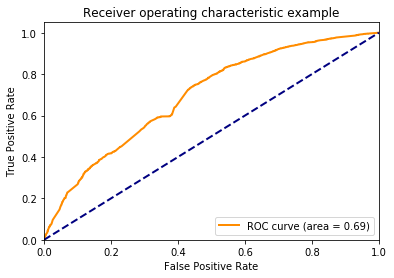

Best_params        [{'C': 0.1}]
F1                         0.98
False negatives               4
False positives            4059
P                           1.0
R                          0.95
Test_ACC                   0.95
Train_ACC                  0.95
True negatives                5
True positives            79910
dtype: object

In [313]:
logreg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }

logreg = fit_algorithm(LogisticRegression(),test3.loc[:, test3.columns != 'CASE_STATUS'],test3.CASE_STATUS,logreg_params)
logreg

[[    5  4059]
 [    4 79910]]
[[ 0.28548312  0.51028714  0.67383171  0.25834187 -0.09994118  0.02253419
  -0.00175694 -0.78086016  0.03866086 -0.00221113]]
0.694906508687
[{'C': 0.1}]


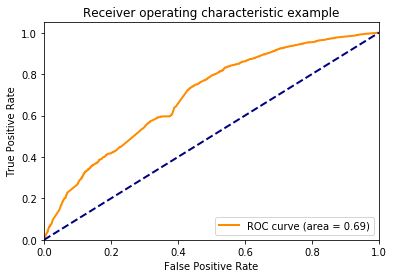

Best_params        [{'C': 0.1}]
F1                         0.98
False negatives               4
False positives            4059
P                           1.0
R                          0.95
Test_ACC                   0.95
Train_ACC                  0.95
True negatives                5
True positives            79910
dtype: object

In [328]:
#rerunning logit with hyperparmeter and no undersampling to see if importance changes when rows are cut
#rerunning logit with the selected hyperparameter to get feature importance
logreg_params = {'C': [0.1] }

logreg = fit_algorithm_imp(LogisticRegression(),test3.loc[:, test3.columns != 'CASE_STATUS'],test3.CASE_STATUS,logreg_params, "logit")
logreg

In [214]:
cart(test3.CASE_STATUS,test3.loc[:, test3.columns != 'CASE_STATUS'])

      0      1
0   706   3449
1  1424  78399
The accuracy score for this training is 0.941972897664
             precision    recall  f1-score   support

          0       0.33      0.17      0.22      4155
          1       0.96      0.98      0.97     79823

avg / total       0.93      0.94      0.93     83978

0.636230700437
10


In [318]:
#raw random forest, no hyperperameters, no under sampling
random_forest(test3.CASE_STATUS,test3.loc[:, test3.columns != 'CASE_STATUS'])

[[  568  3496]
 [  686 79228]]
0.69498503337


F1                  0.97
False negatives      686
False positives     3496
P                   0.99
R                   0.96
True negatives       568
True positives     79228
dtype: object

[[  379  3685]
 [  114 79800]]
0.781271724572
[{'max_depth': 15, 'max_features': 4, 'n_estimators': 40, 'n_jobs': -1, 'random_state': 123}]


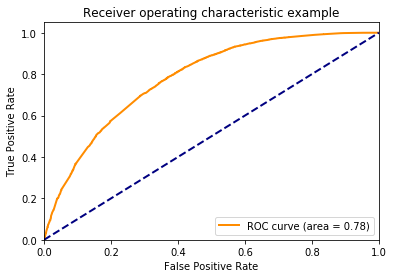

Best_params        [{'max_depth': 15, 'max_features': 4, 'n_estim...
F1                                                              0.98
False negatives                                                  114
False positives                                                 3685
P                                                                1.0
R                                                               0.96
Test_ACC                                                        0.95
Train_ACC                                                       0.95
True negatives                                                   379
True positives                                                 79800
dtype: object

In [317]:
forest_params = {'n_estimators': [10,20,30,40,50],
     'max_depth': [15,20,25,30],
     'max_features': [2,3,4,5],
     'random_state': [123],
     'n_jobs': [-1]
    }
    
# #Importing RandomForestClassifier from sklearn
from sklearn.ensemble import RandomForestClassifier

forest = fit_algorithm(RandomForestClassifier(),test3.loc[:, test3.columns != 'CASE_STATUS'],test3.CASE_STATUS, forest_params)
forest

In [209]:
print(test3['CASE_STATUS'].value_counts() /  test3['CASE_STATUS'].value_counts().sum())
test3_cut = test3.drop(test3.query('CASE_STATUS == 1').sample(frac=.70).index)
print(test3_cut['CASE_STATUS'].value_counts() /  test3_cut['CASE_STATUS'].value_counts().sum())

1    0.950837
0    0.049163
Name: CASE_STATUS, dtype: float64
1    0.855247
0    0.144753
Name: CASE_STATUS, dtype: float64


In [282]:
test3_cut.reset_index(inplace = True)
del test3_cut['index']

In [260]:
#logistic regr, no hyperparameter, under sampled data
logit_regr(test3_cut.CASE_STATUS,test3_cut.loc[:, test3_cut.columns != 'CASE_STATUS'])

           Denied  Certified
Denied         52       1000
Certified      53       6060
The accuracy score for this training is 0.853035589672
             precision    recall  f1-score   support

          0       0.50      0.05      0.09      1052
          1       0.86      0.99      0.92      6113

avg / total       0.81      0.85      0.80      7165

0.697226707528


[[  63  950]
 [  60 6092]]
0.704916546534
[{'C': 10}]


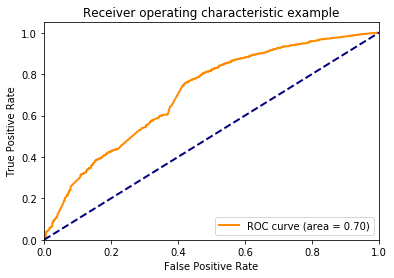

Best_params        [{'C': 10}]
F1                        0.92
False negatives             60
False positives            950
P                         0.99
R                         0.87
Test_ACC                  0.86
Train_ACC                 0.86
True negatives              63
True positives            6092
dtype: object

In [314]:
logreg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }

logreg = fit_algorithm(LogisticRegression(),test3_cut.loc[:, test3_cut.columns != 'CASE_STATUS'],test3_cut.CASE_STATUS,logreg_params)
logreg

[[  63  950]
 [  60 6092]]
[[ 0.04717119  0.41383787  0.750703    0.21815688  0.08378645  0.02636557
  -0.00185426 -0.69284444  0.03820422 -0.00222886]]
0.704916706996
[{'C': 10}]


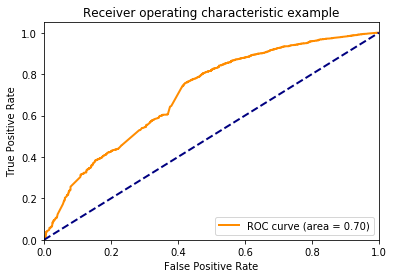

Best_params        [{'C': 10}]
F1                        0.92
False negatives             60
False positives            950
P                         0.99
R                         0.87
Test_ACC                  0.86
Train_ACC                 0.86
True negatives              63
True positives            6092
dtype: object

In [326]:
#rerunning logit with the selected hyperparameter to get feature importance
logreg_params = {'C': [10] }

logreg = fit_algorithm_imp(LogisticRegression(),test3_cut.loc[:, test3_cut.columns != 'CASE_STATUS'],test3_cut.CASE_STATUS,logreg_params, "logit")
logreg

In [215]:
cart(test3_cut.CASE_STATUS,test3_cut.loc[:, test3_cut.columns != 'CASE_STATUS'])

     0     1
0  359   683
1  508  5615
The accuracy score for this training is 0.833775296581
             precision    recall  f1-score   support

          0       0.41      0.34      0.38      1042
          1       0.89      0.92      0.90      6123

avg / total       0.82      0.83      0.83      7165

0.632051109642
10


In [316]:
#random forest, no hyperparameter, undersampling
random_forest(test3_cut.CASE_STATUS,test3_cut.loc[:, test3_cut.columns != 'CASE_STATUS'])

[[ 289  724]
 [ 317 5835]]
0.715388987377


F1                 0.92
False negatives     317
False positives     724
P                  0.95
R                  0.89
True negatives      289
True positives     5835
dtype: object

[[ 241  772]
 [ 147 6005]]
0.764518027669
[{'max_depth': 15, 'max_features': 4, 'n_estimators': 40, 'n_jobs': -1, 'random_state': 123}]


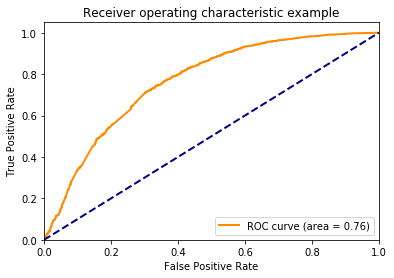

Best_params        [{'max_depth': 15, 'max_features': 4, 'n_estim...
F1                                                              0.93
False negatives                                                  147
False positives                                                  772
P                                                               0.98
R                                                               0.89
Test_ACC                                                        0.87
Train_ACC                                                       0.87
True negatives                                                   241
True positives                                                  6005
dtype: object

In [315]:
forest_params = {'n_estimators': [10,20,30,40,50],
     'max_depth': [15,20,25,30],
     'max_features': [2,3,4,5],
     'random_state': [123],
     'n_jobs': [-1]
    }
    
# #Importing RandomForestClassifier from sklearn
from sklearn.ensemble import RandomForestClassifier

forest = fit_algorithm(RandomForestClassifier(),test3_cut.loc[:, test3_cut.columns != 'CASE_STATUS'],test3_cut.CASE_STATUS, forest_params)
forest

[[ 241  772]
 [ 147 6005]]
[  7.86079241e-06   1.87526055e-02   4.26322336e-02   5.58047134e-02
   2.41826323e-02   1.18459260e-01   4.34645387e-01   2.65642018e-02
   7.93801577e-02   1.99570948e-01]
0.764518027669
[{'max_depth': 15, 'max_features': 4, 'n_estimators': 40, 'n_jobs': -1, 'random_state': 123}]


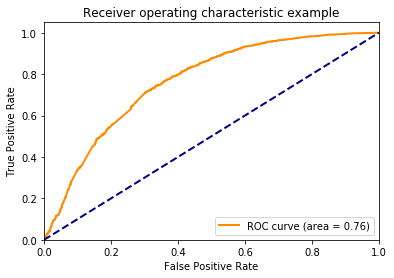

Best_params        [{'max_depth': 15, 'max_features': 4, 'n_estim...
F1                                                              0.93
False negatives                                                  147
False positives                                                  772
P                                                               0.98
R                                                               0.89
Test_ACC                                                        0.87
Train_ACC                                                       0.87
True negatives                                                   241
True positives                                                  6005
dtype: object

In [327]:
#getting feature importances
forest_params = {'n_estimators': [40],
     'max_depth': [15],
     'max_features': [4],
     'random_state': [123],
     'n_jobs': [-1]
    }
    
# #Importing RandomForestClassifier from sklearn
from sklearn.ensemble import RandomForestClassifier

forest = fit_algorithm_imp(RandomForestClassifier(),test3_cut.loc[:, test3_cut.columns != 'CASE_STATUS'],test3_cut.CASE_STATUS, forest_params, "random_forest")
forest

## Clustering

Using test3_cut to cluster on

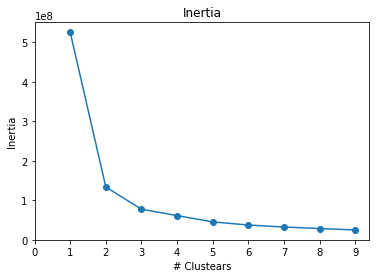

In [220]:
# <help:scikit_k_means_cluster>
import warnings
warnings.filterwarnings('ignore') #notebook outputs warnings, let's ignore them
from time import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn.cluster import KMeans

# set the number of clusters, must be >=1
n = 10
inertia = [np.NaN]

# perform k-means clustering over i=0...k
for k in range(1,n):
    k_means_ = KMeans(n_clusters=k)
    k_means_.fit(test3_cut.loc[:, test3_cut.columns != 'CASE_STATUS'])
    #labels = kmeans.labels_
    #print('k = %d, inertia= %f' % (k, k_means_.inertia_ ))
    inertia.append(k_means_.inertia_) 
    
# plot the SSE of the clusters for each value of i
ax = plt.subplot(111)
ax.plot(inertia, '-o')
plt.xticks(range(n))
plt.title("Inertia")
ax.set_ylabel('Inertia')
ax.set_xlabel('# Clustears')
plt.show() 

In [235]:
clust_t3 = test3_cut.copy()

In [236]:
# <help:scikit_k_means_cluster>
import warnings
warnings.filterwarnings('ignore') #notebook outputs warnings, let's ignore them
from time import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn.cluster import KMeans

# set the number of clusters, must be >=1
n = 2
inertia = [np.NaN]

# perform k-means clustering over i=0...k

k_means_ = KMeans(n_clusters=2)
k_means_.fit(clust_t3.loc[:, clust_t3.columns != 'CASE_STATUS'])
labels = k_means_.labels_
#print('k = %d, inertia= %f' % (k, k_means_.inertia_ ))
inertia.append(k_means_.inertia_) 
    

In [237]:
clust_t3['Cluster_Label'] = labels

In [238]:
clust_t3['Cluster_Label'].value_counts()

0    20258
1     3624
Name: Cluster_Label, dtype: int64

In [228]:
clust_t3.columns

Index(['CASE_STATUS', 'EMPLOYER_COUNTRY', 'RI_POSTED_NOTICE_AT_WORKSITE',
       'JOB_INFO_FOREIGN_ED', 'RECR_INFO_PROFESSIONAL_OCC',
       'PW_SOURCE_NAME_9089', 'CLASS_OF_ADMISSION', 'PW_SOC_CODE',
       'JOB_INFO_JOB_REQ_NORMAL', 'JOB_INFO_EDUCATION',
       'COUNTRY_OF_CITIZENSHIP', 'Cluster_Label'],
      dtype='object')

In [239]:
clust1 = clust_t3.loc[clust_t3['Cluster_Label'] ==0]
clust2 = clust_t3.loc[clust_t3['Cluster_Label'] ==1]


In [240]:
clust1.drop('Cluster_Label', axis = 1, inplace = True)
clust2.drop('Cluster_Label', axis = 1, inplace = True)

In [241]:
logreg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }

logreg = fit_algorithm(LogisticRegression(),clust1.loc[:, clust1.columns != 'CASE_STATUS'],clust1.CASE_STATUS,logreg_params)
logreg

[[   0  724]
 [   0 5354]]
0.604371673371


Best_params        [{'C': 0.001}]
F1                           0.94
False negatives                 0
False positives               724
P                             1.0
R                            0.88
Test_ACC                     0.88
Train_ACC                    0.89
True negatives                  0
True positives               5354
dtype: object

In [242]:
logreg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }

logreg = fit_algorithm(LogisticRegression(),clust2.loc[:, clust2.columns != 'CASE_STATUS'],clust2.CASE_STATUS,logreg_params)
logreg

[[ 44 299]
 [ 37 708]]
0.688107304283


Best_params        [{'C': 1}]
F1                       0.81
False negatives            37
False positives           299
P                        0.95
R                         0.7
Test_ACC                 0.69
Train_ACC                0.71
True negatives             44
True positives            708
dtype: object

In [248]:
#testing out logit with using the cluster label as a feature
logreg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }

logreg = fit_algorithm(LogisticRegression(),clust_t3.loc[:, clust_t3.columns != 'CASE_STATUS'],clust_t3.CASE_STATUS,logreg_params)
logreg

[[  63  950]
 [  56 6096]]
0.704188206116


Best_params        [{'C': 1}]
F1                       0.92
False negatives            56
False positives           950
P                        0.99
R                        0.87
Test_ACC                 0.86
Train_ACC                0.86
True negatives             63
True positives           6096
dtype: object

In [246]:
forest_params = {'n_estimators': [10,20,30,40,50],
     'max_depth': [15,20,25,30],
     'max_features': [2,3,4,5,6,7,8,9,10],
     'random_state': [123],
     'n_jobs': [-1]
    }
    
# #Importing RandomForestClassifier from sklearn
from sklearn.ensemble import RandomForestClassifier

forest = fit_algorithm(RandomForestClassifier(),clust1.loc[:, clust1.columns != 'CASE_STATUS'],clust1.CASE_STATUS, forest_params)
forest

[[ 124  600]
 [  65 5289]]
0.711060894214


Best_params        [{'max_depth': 15, 'max_features': 3, 'n_estim...
F1                                                              0.94
False negatives                                                   65
False positives                                                  600
P                                                               0.99
R                                                                0.9
Test_ACC                                                        0.89
Train_ACC                                                       0.89
True negatives                                                   124
True positives                                                  5289
dtype: object

In [247]:
forest_params = {'n_estimators': [10,20,30,40,50],
     'max_depth': [15,20,25,30],
     'max_features': [2,3,4,5,6,7,8,9,10],
     'random_state': [123],
     'n_jobs': [-1]
    }
    
# #Importing RandomForestClassifier from sklearn
from sklearn.ensemble import RandomForestClassifier

forest = fit_algorithm(RandomForestClassifier(),clust2.loc[:, clust2.columns != 'CASE_STATUS'],clust2.CASE_STATUS, forest_params)
forest

[[101 242]
 [ 88 657]]
0.72553661925


Best_params        [{'max_depth': 15, 'max_features': 2, 'n_estim...
F1                                                               0.8
False negatives                                                   88
False positives                                                  242
P                                                               0.88
R                                                               0.73
Test_ACC                                                         0.7
Train_ACC                                                       0.73
True negatives                                                   101
True positives                                                   657
dtype: object

In [249]:
#testing out random forest with the cluster label as a feature
forest_params = {'n_estimators': [10,20,30,40,50],
     'max_depth': [15,20,25,30],
     'max_features': [2,3,4,5,6,7,8,9,10],
     'random_state': [123],
     'n_jobs': [-1]
    }
    
# #Importing RandomForestClassifier from sklearn
from sklearn.ensemble import RandomForestClassifier

forest = fit_algorithm(RandomForestClassifier(),clust_t3.loc[:, clust_t3.columns != 'CASE_STATUS'],clust_t3.CASE_STATUS, forest_params)
forest

[[ 243  770]
 [ 155 5997]]
0.764113661542


Best_params        [{'max_depth': 15, 'max_features': 4, 'n_estim...
F1                                                              0.93
False negatives                                                  155
False positives                                                  770
P                                                               0.97
R                                                               0.89
Test_ACC                                                        0.87
Train_ACC                                                       0.87
True negatives                                                   243
True positives                                                  5997
dtype: object

Trying 3 clusters

In [295]:
clust_t4 = test3_cut.copy()

In [298]:
# <help:scikit_k_means_cluster>
import warnings
warnings.filterwarnings('ignore') #notebook outputs warnings, let's ignore them
from time import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn.cluster import KMeans

# set the number of clusters, must be >=1
n = 2
inertia = [np.NaN]

# perform k-means clustering over i=0...k

k_means_ = KMeans(n_clusters=3)
k_means_.fit(clust_t4.loc[:, clust_t4.columns != 'CASE_STATUS'])
labels = k_means_.labels_
#print('k = %d, inertia= %f' % (k, k_means_.inertia_ ))
inertia.append(k_means_.inertia_) 
    

In [299]:
clust_t4['Cluster_Label'] = labels
clust_t4.Cluster_Label.value_counts()

1    19154
2     3037
0     1691
Name: Cluster_Label, dtype: int64

In [300]:
clust3 = clust_t4.loc[clust_t4['Cluster_Label'] ==0]
clust4 = clust_t4.loc[clust_t4['Cluster_Label'] ==1]
clust5 = clust_t4.loc[clust_t4['Cluster_Label'] ==1]

In [301]:
clust3.drop('Cluster_Label', axis = 1, inplace = True)
clust4.drop('Cluster_Label', axis = 1, inplace = True)
clust5.drop('Cluster_Label', axis = 1, inplace = True)

In [302]:
logreg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }

logreg = fit_algorithm(LogisticRegression(),clust3.loc[:, clust3.columns != 'CASE_STATUS'],clust3.CASE_STATUS,logreg_params)
logreg

[[ 56 155]
 [ 36 261]]
0.652640145531
[{'C': 10}]


Best_params        [{'C': 10}]
F1                        0.73
False negatives             36
False positives            155
P                         0.88
R                         0.63
Test_ACC                  0.62
Train_ACC                 0.65
True negatives              56
True positives             261
dtype: object

In [303]:
logreg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }

logreg = fit_algorithm(LogisticRegression(),clust4.loc[:, clust4.columns != 'CASE_STATUS'],clust4.CASE_STATUS,logreg_params)
logreg

[[  20  555]
 [  18 5154]]
0.632749083695
[{'C': 10}]


Best_params        [{'C': 10}]
F1                        0.95
False negatives             18
False positives            555
P                          1.0
R                          0.9
Test_ACC                   0.9
Train_ACC                 0.89
True negatives              20
True positives            5154
dtype: object

In [304]:
logreg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }

logreg = fit_algorithm(LogisticRegression(),clust5.loc[:, clust5.columns != 'CASE_STATUS'],clust5.CASE_STATUS,logreg_params)
logreg

[[  20  555]
 [  18 5154]]
0.632817007969
[{'C': 100}]


Best_params        [{'C': 100}]
F1                         0.95
False negatives              18
False positives             555
P                           1.0
R                           0.9
Test_ACC                    0.9
Train_ACC                  0.89
True negatives               20
True positives             5154
dtype: object

In [309]:
#trying logit with cluster label as a feature
logreg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }

logreg = fit_algorithm(LogisticRegression(),clust_t4.loc[:, clust_t4.columns != 'CASE_STATUS'],clust_t4.CASE_STATUS,logreg_params)
logreg

[[  62  951]
 [  60 6092]]
0.703866959693
[{'C': 0.1}]


Best_params        [{'C': 0.1}]
F1                         0.92
False negatives              60
False positives             951
P                          0.99
R                          0.86
Test_ACC                   0.86
Train_ACC                  0.86
True negatives               62
True positives             6092
dtype: object

In [305]:
forest_params = {'n_estimators': [10,20,30,40,50],
     'max_depth': [15,20,25,30],
     'max_features': [2,3,4,5,6,7,8,9,10],
     'random_state': [123],
     'n_jobs': [-1]
    }

In [306]:
forest = fit_algorithm(RandomForestClassifier(),clust3.loc[:, clust3.columns != 'CASE_STATUS'],clust3.CASE_STATUS, forest_params)
forest

[[127  84]
 [ 91 206]]
0.720530741858
[{'max_depth': 15, 'max_features': 4, 'n_estimators': 20, 'n_jobs': -1, 'random_state': 123}]


Best_params        [{'max_depth': 15, 'max_features': 4, 'n_estim...
F1                                                               0.7
False negatives                                                   91
False positives                                                   84
P                                                               0.69
R                                                               0.71
Test_ACC                                                        0.66
Train_ACC                                                       0.65
True negatives                                                   127
True positives                                                   206
dtype: object

In [307]:
forest = fit_algorithm(RandomForestClassifier(),clust4.loc[:, clust4.columns != 'CASE_STATUS'],clust4.CASE_STATUS, forest_params)
forest

[[  60  515]
 [  30 5142]]
0.702613235146
[{'max_depth': 15, 'max_features': 2, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 123}]


Best_params        [{'max_depth': 15, 'max_features': 2, 'n_estim...
F1                                                              0.95
False negatives                                                   30
False positives                                                  515
P                                                               0.99
R                                                               0.91
Test_ACC                                                        0.91
Train_ACC                                                        0.9
True negatives                                                    60
True positives                                                  5142
dtype: object

In [308]:
forest = fit_algorithm(RandomForestClassifier(),clust5.loc[:, clust5.columns != 'CASE_STATUS'],clust5.CASE_STATUS, forest_params)
forest

[[  60  515]
 [  30 5142]]
0.702613235146
[{'max_depth': 15, 'max_features': 2, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 123}]


Best_params        [{'max_depth': 15, 'max_features': 2, 'n_estim...
F1                                                              0.95
False negatives                                                   30
False positives                                                  515
P                                                               0.99
R                                                               0.91
Test_ACC                                                        0.91
Train_ACC                                                        0.9
True negatives                                                    60
True positives                                                  5142
dtype: object

In [310]:
#trying random forest with cluster label as a feature
forest = fit_algorithm(RandomForestClassifier(),clust_t4.loc[:, clust_t4.columns != 'CASE_STATUS'],clust_t4.CASE_STATUS, forest_params)
forest

[[ 240  773]
 [ 151 6001]]
0.766751428439
[{'max_depth': 15, 'max_features': 2, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 123}]


Best_params        [{'max_depth': 15, 'max_features': 2, 'n_estim...
F1                                                              0.93
False negatives                                                  151
False positives                                                  773
P                                                               0.98
R                                                               0.89
Test_ACC                                                        0.87
Train_ACC                                                       0.87
True negatives                                                   240
True positives                                                  6001
dtype: object